In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *
import random

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, silhouette_score

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics


In [2]:
fight_Data = pd.read_csv("MasterData_copy.csv")

#fight_Data.head()

fight_Data = fight_Data.dropna()

Question 1
A and C - I changed this question to what are the main predictors behind winning a greater number of fights? I did this because I was unable to easily use a linear regression on my selected data set. 

In [15]:
fight_Data['Stance_dummy'] = 0


for i in range(len(fight_Data)):
    if(fight_Data['R_Stance'].iloc[i] == 'Orthodox'):
        fight_Data['Stance_dummy'].iloc[i] = 0.0
        
    if(fight_Data['R_Stance'].iloc[i] == 'Southpaw'):
        fight_Data['Stance_dummy'].iloc[i] = 1.0

    if(fight_Data['R_Stance'].iloc[i] == 'Switch'):
        fight_Data['Stance_dummy'].iloc[i] = 2.0




predictors = ["R_avg_HEAD_landed" , "R_avg_KD" ,"R_avg_HEAD_att" , "R_avg_GROUND_att", "R_avg_SUB_ATT", "R_avg_SUB_ATT", "R_avg_BODY_landed" , 
              "R_avg_BODY_att" , "R_avg_LEG_att", "R_avg_LEG_landed","R_avg_SIG_STR_att" ,  "R_avg_SIG_STR_landed" , "R_avg_TD_landed" , "R_avg_TD_att" , "R_Weight_lbs" , "R_age", "Stance_dummy"]

X_train, X_test, y_train, y_test = train_test_split(fight_Data[predictors], fight_Data["R_wins"], test_size=0.2)


zscore = StandardScaler()
zscore.fit(X_train)

Xz_train = zscore.transform(X_train)
Xz_test = zscore.transform(X_test)

LinReg = LinearRegression() # create

LinReg.fit(Xz_train, y_train) #fit

predictedVals = LinReg.predict(Xz_test)# predict


#mean_squared_error(y_test, LinReg.predict(Xz_test))
#fight_Data['Stance_dummy'].value_counts()
#print(Ocount)
#LinReg.coef_

10.858739927747326

In [4]:
rr = Ridge()


rr.fit(X_train,y_train)

print("TRAIN: ", mean_absolute_error(y_train, rr.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, rr.predict(X_test)))

TRAIN:  2.642176031988846
TEST :  2.70184433959336


In [5]:
true_vs_pred = pd.DataFrame({"predict": predictedVals,"trueV": y_test})
true_vs_pred.head()

,predict,trueV
1836,3.795104,1
1225,5.012357,4
2179,3.227298,0
3430,3.964013,1
4778,8.397971,7


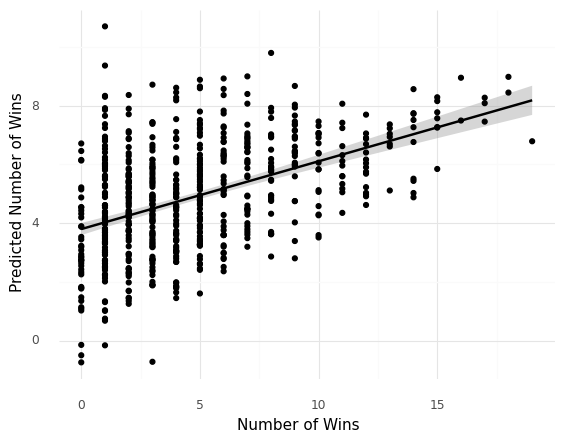

<ggplot: (307023457)>

In [6]:
(ggplot(true_vs_pred, aes(x = "trueV", y = "predict")) + stat_smooth(method = "lm") + theme_minimal()+ labs(x = "Number of Wins", y = "Predicted Number of Wins") +geom_point())

Our linear regression did a fairly good job of predicting how many wins would be earned given all of the predictors showing a positive relationship (shown on the stat smooth line).

In [7]:
R_LEG_pct = fight_Data['R_avg_LEG_landed'] / fight_Data['R_avg_LEG_att']

R_BODY_pct = fight_Data['R_avg_BODY_landed'] / fight_Data['R_avg_BODY_att']

R_HEAD_pct = fight_Data['R_avg_HEAD_landed'] / fight_Data['R_avg_HEAD_att']


fight_Data['R_HEAD_pct'] = R_HEAD_pct
fight_Data['R_BODY_pct'] = R_BODY_pct
fight_Data['R_LEG_pct'] = R_LEG_pct

fight_Data['dummy'] = np.nan

for i in range(len(fight_Data)):
    if(fight_Data['R_HEAD_pct'].iloc[i] >= fight_Data['R_BODY_pct'].iloc[i]):
        if(fight_Data['R_HEAD_pct'].iloc[i] >= fight_Data['R_LEG_pct'].iloc[i]):
            fight_Data['dummy'].iloc[i] = "Head"
            
    if(fight_Data['R_BODY_pct'].iloc[i] >= fight_Data['R_HEAD_pct'].iloc[i]):
        if(fight_Data['R_BODY_pct'].iloc[i] >= fight_Data['R_LEG_pct'].iloc[i]):
            fight_Data['dummy'].iloc[i] = "Body"

    if(fight_Data['R_LEG_pct'].iloc[i] >= fight_Data['R_HEAD_pct'].iloc[i]):
        if(fight_Data['R_LEG_pct'].iloc[i] >= fight_Data['R_BODY_pct'].iloc[i]):
            fight_Data['dummy'].iloc[i] = "Leg"



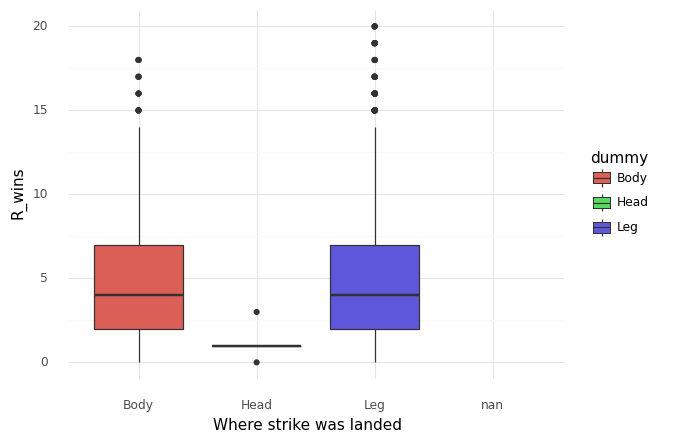

<ggplot: (308353973)>

In [8]:
(ggplot(fight_Data, aes(x = "dummy", y = "R_wins", fill = "dummy"))+ 
 geom_boxplot() + 
 theme_minimal()+ labs(x = "Where strike was landed"))

This graph shows us that landing a higher percentage of strikes on the legs and body would on average give the fighter a higher liklihood of winning more fights. Head strikes are rarely hit in high percentage so it may not be a viable long term strategy for winning.

Question 1 B - The main predictors behind fights in the ufc as shown in our linear regression are attempted head strikes, age, and significant strikes landed. This is interesting because in our second graph we saw head strikes were not landed at a high percentage among successfull fighters. However, this may tell us that it may be less about actually landing head shots and more about making the opposing fighter respect your knockout power. Throwing more head strikes may cause an opponent to fight you differently. 


Question 2 A and C - I had to change this question because now with predicting how many wins a fighter would have, a fighter with higher age would most likely have more wins due to longevity. I decided to change this question to 

"Does Stance and/or Weight play a role in how many wins a fighter can accumulate?"

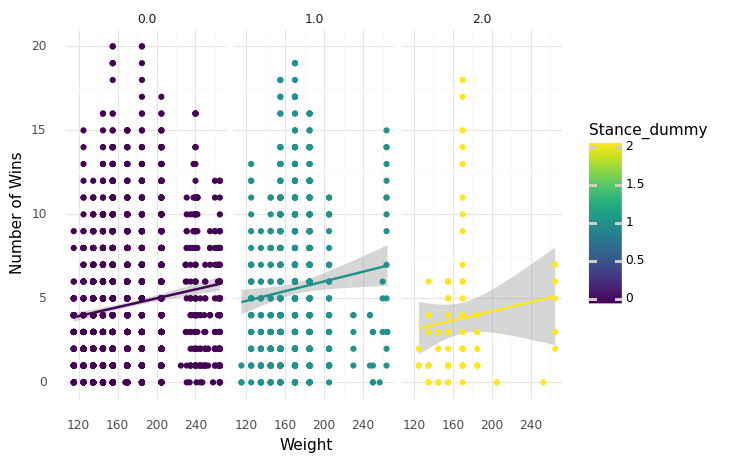

<ggplot: (271392338)>

In [9]:
(ggplot(fight_Data, aes(x = "R_Weight_lbs", y = "R_wins", color = "Stance_dummy")) + theme_minimal()+ stat_smooth(method = "lm") +facet_wrap("~Stance_dummy")+labs(x = "Weight", y = "Number of Wins") + geom_point())

This graph indicates to us that "Orthodox" fighters (left) are the most common and have the second most wins on average and very little disparity compared to the other stances. "Southpaw's" (middle) have the highest average number of wins with a bit of a larger disparity compared to the other stances, and the final category is "Switch" (right) stances which have the largest disparity but have the lowest overall average wins compared to the other stances across all weights. 

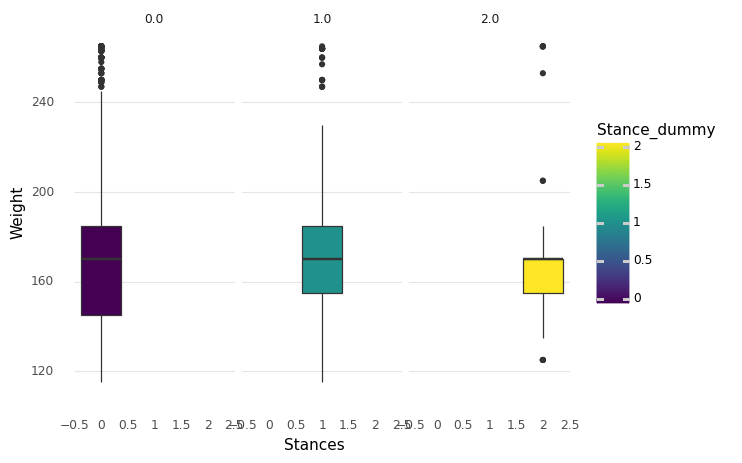

<ggplot: (306746305)>

In [10]:
(ggplot(fight_Data, aes(x = "Stance_dummy", y = "R_Weight_lbs", fill = "Stance_dummy")) + theme_minimal() + labs(x = "Stances", y = "Weight")+ theme(panel_grid_major_x = element_blank(),
      panel_grid_minor_x = element_blank(), 
      panel_grid_minor_y = element_blank()) + facet_wrap("~Stance_dummy")+ geom_boxplot())

This graph further illustrates the relatiobship between weights and stances. Orthodox and Southpaw have fairly even distributions across all weight classes, while Switch seems to get phased out of the equation around 170 lbs. (Disregard extra numers on X axis, without facet_wrap, only 1 boxplot was displayed)

Quesiton 2 B - The answer to this question is between Southpaw and Orthodox, there's no clear cut preferred stance, however Switch stance fighters will have a tough time accumulating wins especially at higher weight classes.

Question 3 A and C - differences in fighting style and whether certain styles have more wins.

In [11]:
features = ["R_avg_HEAD_att" , "R_avg_GROUND_att" ,"R_avg_CLINCH_att" , 
              "R_avg_BODY_att" , "R_avg_SIG_STR_att" ,"R_avg_TD_att" ,"R_Weight_lbs", "R_avg_SUB_ATT" , "R_age"]

X = fight_Data[features]

z = StandardScaler()

X[features] = z.fit_transform(X)

km = KMeans(n_clusters = 7, random_state = 10)
km.fit(X)

membership = km.predict(X)

silhouette_score(X,membership)

X["clusters"] = membership


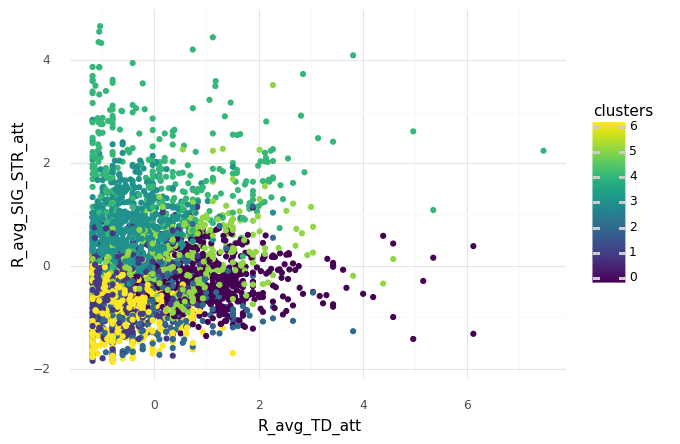

<ggplot: (306268224)>

In [12]:
ggplot(X, aes("R_avg_TD_att", "R_avg_SIG_STR_att", color = "clusters")) + geom_point() + theme_minimal()

This scatterplot shows us 3 idetifiable groups. The first two which would be all the green clusters are hugging the y axis all the way up. This group would be martial artists that focus on more power strikes like krav maga or boxing. The other identifiable grous would be the yellow and blue clusters closer to the x axis. This would definitely be your jiu jitsu masters or former pro wrestlers as those is the most prevalent takedown methods in mma. 

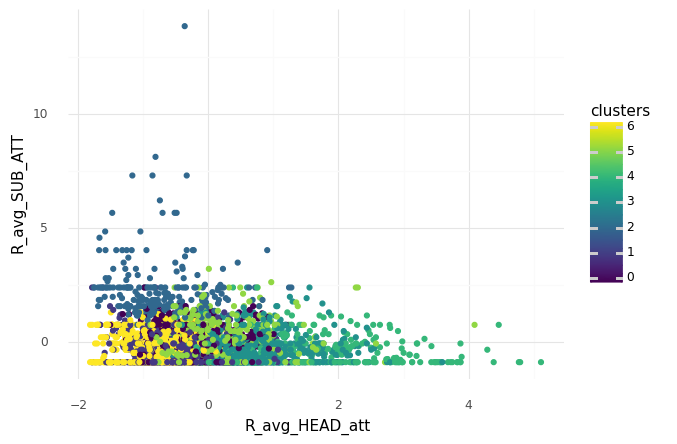

<ggplot: (307310987)>

In [13]:
ggplot(X, aes("R_avg_HEAD_att", "R_avg_SUB_ATT", color = "clusters")) + geom_point() + theme_minimal()

In this graph, our clusters mentioned in the previous graph are only reinforced. The blue and purple clusters which had high takedowns, also have high submission attempts. This leads me to believe the blue would be jiu jitsu masters looking for submissions while the purple are wrestlers lookin for takedowns to score more points. Our green clusters are also the groups with high head strike attempts. This tells me that a large majority of the Significant strikes thrown in mma are aimed at the head. 

Question 3 B - From the information displayed in my clustering graphs coupled with the insights taken from my linear regression, I can concurr that having boxing and takedown (jiu jitsu/wrestling) experience are the most important to have to excel in the ufc.